In [17]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch  
import torch.nn as nn
import torch.optim as optim  
from diffusers import UNet2DConditionModel, DDPMScheduler
from ectutorial.data import get_ett_dataset
from genrisk.generation import TCNGAN
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import math
import wandb
import tqdm
# from ts2vec import TS2Vec

In [3]:
ett = get_ett_dataset()
ett.head()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
date,,,,,,,
2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [4]:
def batch_generator(data, batch_size):
    no = len(data)
    idx = np.random.permutation(no)
    train_idx = idx[:batch_size]
    X_mb = data[train_idx]
    return X_mb

class RNNDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(RNNDiscriminator, self).__init__()
        self.hidden_dim = hidden_dim
        self.gru = nn.GRU(input_size, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        gru_out, _ = self.gru(x)
        last_hidden = gru_out[:, -1, :]
        y_hat_logit = self.fc(last_hidden)
        y_hat = self.sigmoid(y_hat_logit)
        return y_hat_logit, y_hat

def discriminative_score_metrics(ori_data, generated_data):

    
    no, dim = ori_data.shape
    hidden_dim = int(dim / 2)
    iterations = 2000
    batch_size = 128

    discriminator = RNNDiscriminator(input_size=dim, hidden_dim=hidden_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(discriminator.parameters())

    train_x, train_x_hat, test_x, test_x_hat = train_test_divide(ori_data, generated_data)

    for itt in tqdm(range(iterations), desc='training', total=iterations):
        X_mb = batch_generator(train_x, batch_size)
        X_hat_mb = batch_generator(train_x_hat, batch_size)

        X_mb = torch.tensor(X_mb, dtype=torch.float32).unsqueeze(1).requires_grad_(True)
        X_hat_mb = torch.tensor(X_hat_mb, dtype=torch.float32).unsqueeze(1).requires_grad_(True)

        optimizer.zero_grad()

        y_logit_real, y_pred_real = discriminator(X_mb)
        y_logit_fake, y_pred_fake = discriminator(X_hat_mb)

        real_labels = torch.ones_like(y_logit_real)
        fake_labels = torch.zeros_like(y_logit_fake)
        d_loss_real = criterion(y_pred_real, real_labels)
        d_loss_fake = criterion(y_pred_fake, fake_labels)
        d_loss = d_loss_real + d_loss_fake

        d_loss.backward()
        optimizer.step()

    with torch.no_grad():
        test_x = torch.tensor(test_x, dtype=torch.float32).unsqueeze(1)
        test_x_hat = torch.tensor(test_x_hat, dtype=torch.float32).unsqueeze(1)

        y_pred_real_curr = discriminator(test_x)[1].numpy()
        y_pred_fake_curr = discriminator(test_x_hat)[1].numpy()

    y_pred_final = np.squeeze(np.concatenate((y_pred_real_curr, y_pred_fake_curr), axis=0))
    y_label_final = np.concatenate((np.ones([len(y_pred_real_curr)]), np.zeros([len(y_pred_fake_curr)])), axis=0)

    acc = accuracy_score(y_label_final, (y_pred_final > 0.5))

    fake_acc = accuracy_score(np.zeros([len(y_pred_fake_curr)]), (y_pred_fake_curr > 0.5))
    real_acc = accuracy_score(np.ones([len(y_pred_real_curr)]), (y_pred_real_curr > 0.5))

    discriminative_score = np.abs(0.5 - acc)
    return discriminative_score, fake_acc, real_acc

In [5]:
def cacf_torch(x, max_lag, dim=(0, 1)):
    def get_lower_triangular_indices(n):
        return [list(x) for x in torch.tril_indices(n, n)]

    ind = get_lower_triangular_indices(x.shape[2])
    x = (x - x.mean(dim, keepdims=True)) / x.std(dim, keepdims=True)
    x_l = x[..., ind[0]]
    x_r = x[..., ind[1]]
    cacf_list = list()
    for i in range(max_lag):
        y = x_l[:, i:] * x_r[:, :-i] if i > 0 else x_l * x_r
        cacf_i = torch.mean(y, (1))
        cacf_list.append(cacf_i)
    cacf = torch.cat(cacf_list, 1)
    return cacf.reshape(cacf.shape[0], -1, len(ind[0]))


class Loss(nn.Module):
    def __init__(self, name, reg=1.0, transform=lambda x: x, threshold=10., backward=False, norm_foo=lambda x: x):
        super(Loss, self).__init__()
        self.name = name
        self.reg = reg
        self.transform = transform
        self.threshold = threshold
        self.backward = backward
        self.norm_foo = norm_foo

    def forward(self, x_fake):
        self.loss_componentwise = self.compute(x_fake)
        return self.reg * self.loss_componentwise.mean()

    def compute(self, x_fake):
        raise NotImplementedError()

    @property
    def success(self):
        return torch.all(self.loss_componentwise <= self.threshold)


class CrossCorrelLoss(Loss):
    def __init__(self, x_real, **kwargs):
        super(CrossCorrelLoss, self).__init__(norm_foo=lambda x: torch.abs(x).sum(0), **kwargs)
        self.cross_correl_real = cacf_torch(self.transform(x_real), 1).mean(0)[0]

    def compute(self, x_fake):
        cross_correl_fake = cacf_torch(self.transform(x_fake), 1).mean(0)[0]
        loss = self.norm_foo(cross_correl_fake - self.cross_correl_real.to(x_fake.device))
        return loss / 10.

In [6]:

def positional_encoding(index, freqs):
    encoding = []
    for freq in freqs:
        values = getattr(index, freq)
        num_values = max(values) + 1
        steps = [x * 2.0 * np.pi / num_values for x in values]
        encoding.append(pd.DataFrame({f'{freq}_cos': np.cos(steps), f'{freq}_sin': np.sin(steps)}, index=index))
    encoding = pd.concat(encoding, axis=1)
    return encoding

def compare_orig_and_fake(orig_data: torch.Tensor, fake_data: torch.Tensor, num_timestamps=50)-> None:
    columns = ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL', 'OT']
    if str(type(orig_data)) == "<class 'pandas.core.frame.DataFrame'>":
        orig_data = torch.tensor(orig_data.values)
    if str(type(fake_data)) == "<class 'pandas.core.frame.DataFrame'>":
        fake_data = torch.tensor(fake_data.values)
    m, n = fake_data.shape
    for i in range(n):
        plt.figure(figsize=(10, 4))
        plt.plot(orig_data[:num_timestamps, i], label=f"orig - Column {i}")
        plt.plot(fake_data[:num_timestamps, i], label=f"fake - Column {i}")
        plt.title(columns[i])
        plt.xlabel('Index')
        plt.ylabel('Value')
        plt.legend()
        plt.show()



In [7]:
def display_scores(results):
    mean = np.mean(results)
    sigma = scipy.stats.sem(results)
    sigma = sigma * scipy.stats.t.ppf((1 + 0.95) / 2., 5-1)
    print('Final Score: ', f'{mean} \xB1 {sigma}')

def train_test_divide(data_x, data_x_hat, train_rate=0.8):
    """Divide train and test data for both original and synthetic data.

    Args:
        - data_x: original data
        - data_x_hat: generated data
        - train_rate: ratio of training data from the original data
    """
    # Divide train/test index (original data)
    no = len(data_x)
    idx = np.random.permutation(no)
    train_idx = idx[:int(no*train_rate)]
    test_idx = idx[int(no*train_rate):]

    train_x = data_x[train_idx]
    test_x = data_x[test_idx]
    
    # Divide train/test index (synthetic data)
    train_x_hat = data_x_hat[train_idx]
    test_x_hat = data_x_hat[test_idx]

    return train_x, train_x_hat, test_x, test_x_hat

def visualization(ori_data, generated_data, analysis='pca', compare=3000):
    # Analysis sample size (for faster computation)
    anal_sample_no = min([compare, ori_data.shape[0]])
    idx = np.random.permutation(ori_data.shape[0])[:anal_sample_no]

    ori_data = ori_data[idx]
    generated_data = generated_data[idx]

    # Visualization parameter
    colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]

    if analysis == 'pca':
        # PCA Analysis
        pca = PCA(n_components=2)
        pca.fit(ori_data)
        pca_results = pca.transform(ori_data)
        pca_hat_results = pca.transform(generated_data)

        # Plotting
        f, ax = plt.subplots(1)
        plt.scatter(pca_results[:, 0], pca_results[:, 1], c=colors[:anal_sample_no], alpha=0.2, label="Original")
        plt.scatter(pca_hat_results[:, 0], pca_hat_results[:, 1], c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")

        ax.legend()
        plt.title('PCA plot')
        plt.xlabel('x-pca')
        plt.ylabel('y_pca')
        plt.show()

    elif analysis == 'tsne':
        # Do t-SNE Analysis together
        prep_data_final = np.concatenate((ori_data, generated_data), axis=0)

        # TSNE analysis
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(prep_data_final)

        # Plotting
        f, ax = plt.subplots(1)
        plt.scatter(tsne_results[:anal_sample_no, 0], tsne_results[:anal_sample_no, 1], c=colors[:anal_sample_no], alpha=0.2, label="Original")
        plt.scatter(tsne_results[anal_sample_no:, 0], tsne_results[anal_sample_no:, 1], c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")

        ax.legend()
        plt.title('t-SNE plot')
        plt.xlabel('x-tsne')
        plt.ylabel('y_tsne')
        plt.show()

    elif analysis == 'kernel':
        # Visualization parameter
        f, ax = plt.subplots(1)
        sns.distplot(ori_data.flatten(), hist=False, kde=True, kde_kws={'linewidth': 5}, label='Original', color="red")
        sns.distplot(generated_data.flatten(), hist=False, kde=True, kde_kws={'linewidth': 5, 'linestyle':'--'}, label='Synthetic', color="blue")
        plt.legend()
        plt.xlabel('Data Value')
        plt.ylabel('Data Density Estimate')
        plt.show()
        plt.close()


In [8]:
val_thresh = int(ett.shape[0] * 0.7)
test_thresh = int(ett.shape[0] * 0.85)

train_data = ett.iloc[:val_thresh].copy()
val_data = ett.iloc[val_thresh:test_thresh].copy()
test_data = ett.iloc[test_thresh:].copy()

In [9]:
test_cond = positional_encoding(test_data.index, ['dayofweek', 'day', 'month'])
train_cond = positional_encoding(train_data.index, ['dayofweek', 'day', 'month'])
val_cond = positional_encoding(val_data.index, ['dayofweek', 'day', 'month'])


In [10]:

scaler = StandardScaler()
train_data.loc[:, ett.columns] = scaler.fit_transform(train_data.loc[:, ett.columns])
val_data.loc[:, ett.columns] = scaler.transform(val_data.loc[:, ett.columns])
test_data.loc[:, ett.columns] = scaler.transform(test_data.loc[:, ett.columns])

dim_time_series = len(train_data.columns)# Размерность временного ряда
dim_cond = len(train_cond.columns)
train_data_tensor = torch.tensor(train_data.values).float()  # Данные временного ряда
train_cond_tensor = torch.tensor(train_cond.values).float()
test_data_tensor = torch.tensor(test_data.values).float() # Данные временного ряда
test_cond_tensor = torch.tensor(test_cond.values).float()
val_data_tensor = torch.tensor(val_data.values).float()  # Данные временного ряда
val_cond_tensor = torch.tensor(val_cond.values).float()

dim_time_series = len(train_data.columns)# Размерность временного ряда
dim_cond = len(train_cond.columns)


In [11]:
print('train_data_tensor shape = ', train_data_tensor.shape)
print('train_cond_tensor shape = ', train_cond_tensor.shape)
print('dim_time_series shape = ', dim_time_series)
print('dim_cond shape = ', dim_cond)

train_data_tensor shape =  torch.Size([12194, 7])
train_cond_tensor shape =  torch.Size([12194, 6])
dim_time_series shape =  7
dim_cond shape =  6


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
device

device(type='cuda')

In [13]:
train_data_tensor_reshaped = train_data_tensor.unsqueeze(1)
print(train_data_tensor.numpy().shape, train_data_tensor.numpy().shape)
# Context_FID(train_data_tensor_reshaped.numpy(), train_data_tensor_reshaped.numpy())

(12194, 7) (12194, 7)


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class DiffusionModel(nn.Module):
    def __init__(self, dim_time_series, dim_cond):
        super(DiffusionModel, self).__init__()
        self.dim_time_series = dim_time_series
        self.dim_cond = dim_cond
        self.unet = UNet2DConditionModel(
            conv_in_kernel=7, 
            conv_out_kernel=7, 
            sample_size=1,
            in_channels=dim_time_series,
            out_channels=dim_time_series,
            down_block_types=('DownBlock2D', 'DownBlock2D'),
            mid_block_type='UNetMidBlock2D',
            up_block_types=('UpBlock2D', 'UpBlock2D'),
            block_out_channels=(16, 32),
            layers_per_block=2,
            norm_num_groups=4,
            cross_attention_dim=dim_cond,
            attention_head_dim=4
        )
        self.scheduler = DDPMScheduler(num_train_timesteps=200)

    def forward(self, x, cond, t):
        x = x.float()
        cond = cond.float()
        x = x.unsqueeze(2).unsqueeze(3)
        cond = cond.unsqueeze(1)
        return self.unet(x, t, encoder_hidden_states=cond).sample

    def train_model(self, train_data, train_cond, epochs=100, lr=0.001):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        device = next(self.parameters()).device  # Ensure model and data are on the same device

        for epoch in range(epochs):
            self.train()
            optimizer.zero_grad()
            timesteps = torch.randint(0, self.scheduler.config.num_train_timesteps, (train_data.size(0),), device=device).long()
            
            noise = torch.randn_like(train_data)
            noisy_data = self.scheduler.add_noise(train_data, noise, timesteps)
            
            output = self.forward(noisy_data, train_cond, timesteps)
            
            loss = criterion(output.squeeze(2).squeeze(2), noise)
            loss.backward()
            optimizer.step()
            print(f'Epoch {epoch + 1}, Loss: {loss.item()}')

    def sample(self, cond_test, num_sample):
        self.eval()
        samples = []
        device = next(self.parameters()).device  # Ensure model and data are on the same device

        for _ in range(num_sample):
            x = torch.randn((cond_test.shape[0], self.dim_time_series)).to(device).float()
            for t in reversed(range(self.scheduler.config.num_train_timesteps)):
                timesteps = torch.tensor([t], device=device).long()
                with torch.no_grad():
                    model_output = self.forward(x, cond_test, timesteps)
                scheduler_output = self.scheduler.step(model_output, t, x.unsqueeze(2).unsqueeze(3))
                x = scheduler_output.prev_sample.squeeze(3).squeeze(2)
            samples.append(x)
        return torch.stack(samples)

dim_time_series = 7
dim_cond = 7

model = DiffusionModel(dim_time_series, dim_cond)
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Количество параметров модели: {num_parameters}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_data_tensor = train_data_tensor.float().to(device)
train_cond_tensor = train_cond_tensor.float().to(device)
model.train_model(train_data_tensor, train_cond_tensor, epochs=400, lr=0.002)


Количество параметров модели: 216807
Epoch 1, Loss: 1.0043953657150269
Epoch 2, Loss: 0.9932647347450256
Epoch 3, Loss: 0.9670436382293701
Epoch 4, Loss: 0.9537283182144165
Epoch 5, Loss: 0.9368685483932495
Epoch 6, Loss: 0.9316139817237854
Epoch 7, Loss: 0.9160711765289307
Epoch 8, Loss: 0.9061902761459351
Epoch 9, Loss: 0.8954562544822693
Epoch 10, Loss: 0.8797011971473694
Epoch 11, Loss: 0.872270941734314
Epoch 12, Loss: 0.8598677515983582
Epoch 13, Loss: 0.8539932370185852
Epoch 14, Loss: 0.843532145023346
Epoch 15, Loss: 0.8291710019111633
Epoch 16, Loss: 0.8182711601257324
Epoch 17, Loss: 0.8099755644798279
Epoch 18, Loss: 0.7922117114067078
Epoch 19, Loss: 0.7830566763877869
Epoch 20, Loss: 0.776079535484314
Epoch 21, Loss: 0.7598454356193542
Epoch 22, Loss: 0.7570425271987915
Epoch 23, Loss: 0.7414882183074951
Epoch 24, Loss: 0.7364359498023987
Epoch 25, Loss: 0.722049355506897
Epoch 26, Loss: 0.7094587683677673
Epoch 27, Loss: 0.6951388716697693
Epoch 28, Loss: 0.6912322640419

In [25]:
num_parameters = sum(p.numel() for p in model.parameters())
print(f"Количество параметров модели: {num_parameters}")

Количество параметров модели: 216807


In [26]:
generated_samples = model.sample(test_cond_tensor, num_sample=1)
one_sample = generated_samples[0, :, :].squeeze(0)
# Генерируем по тесту


In [33]:
one_sample = one_sample.to('cpu')
one_sample

tensor([[-0.2481,  0.3746, -0.4272,  ...,  0.7616, -0.8320, -0.4969],
        [-0.2882,  0.7904, -0.4248,  ...,  0.9874,  0.7611,  0.9613],
        [ 0.2207, -0.7190,  0.0983,  ..., -0.9928, -0.5229, -0.9493],
        ...,
        [-0.7825,  0.4506, -0.8194,  ...,  0.2656,  0.5058, -0.1645],
        [-0.5087,  0.6363, -1.0000,  ...,  0.7181,  0.7133,  0.4423],
        [ 0.2633,  0.4959,  0.6775,  ..., -0.7139, -0.6127,  0.3027]])

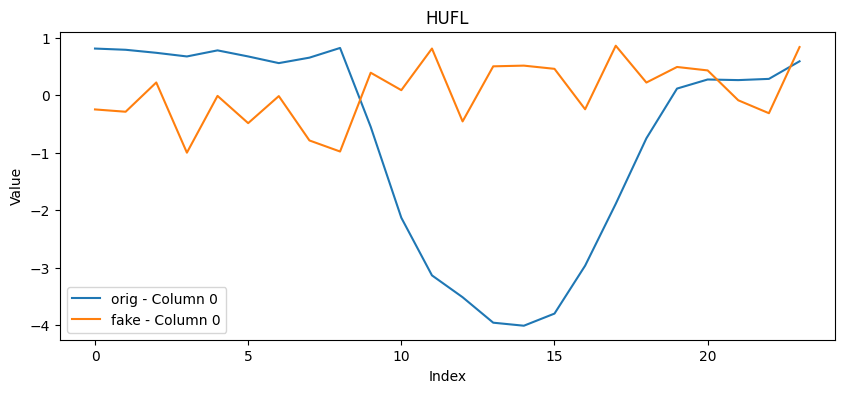

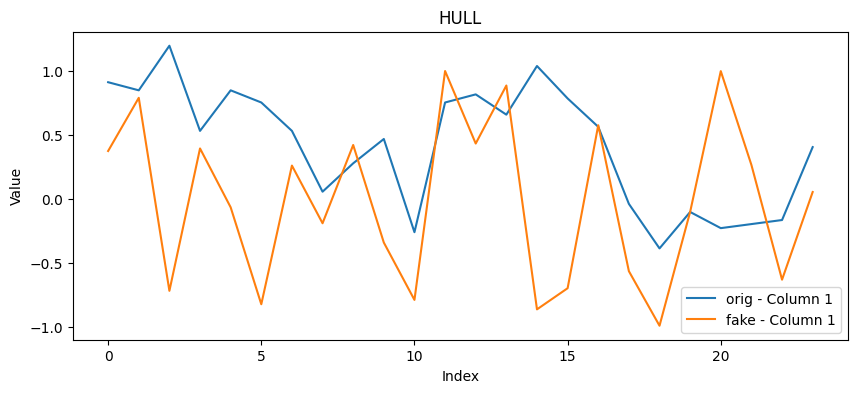

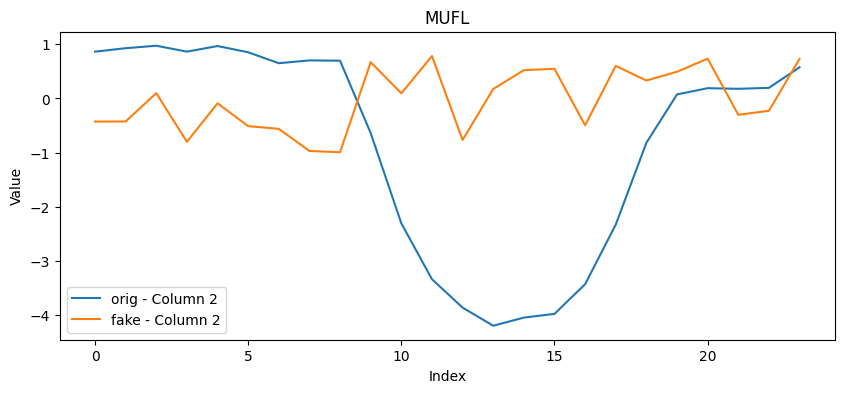

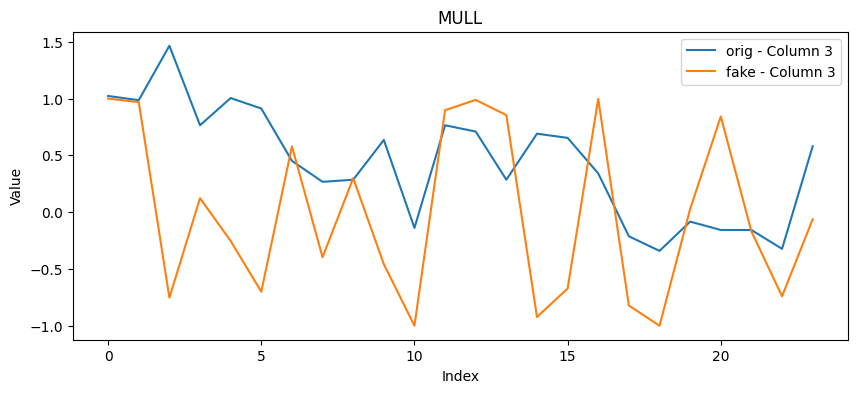

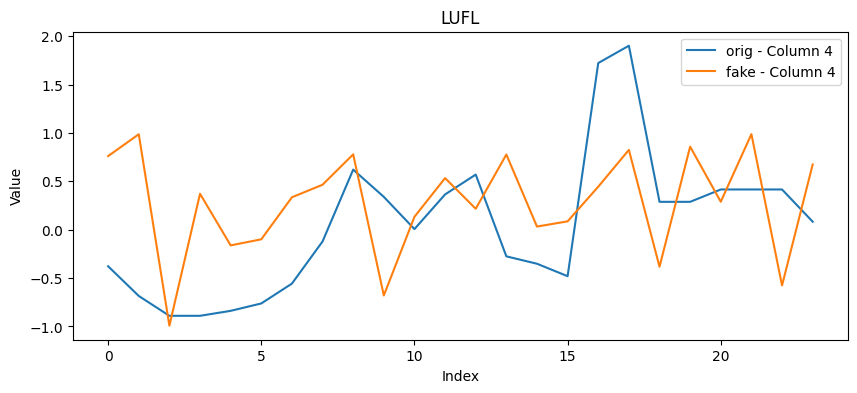

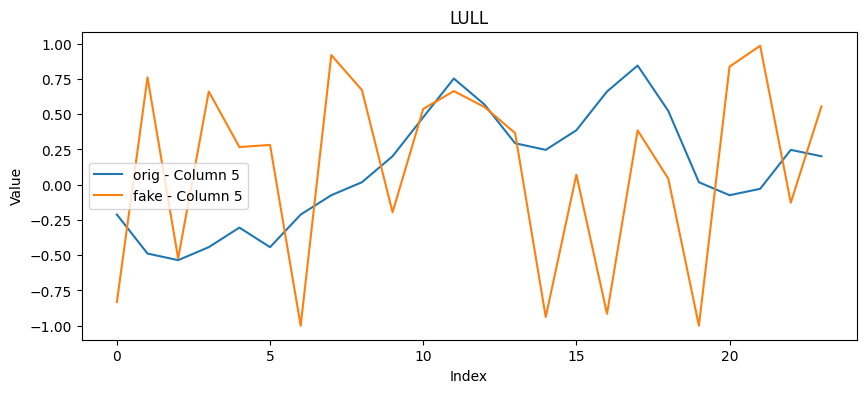

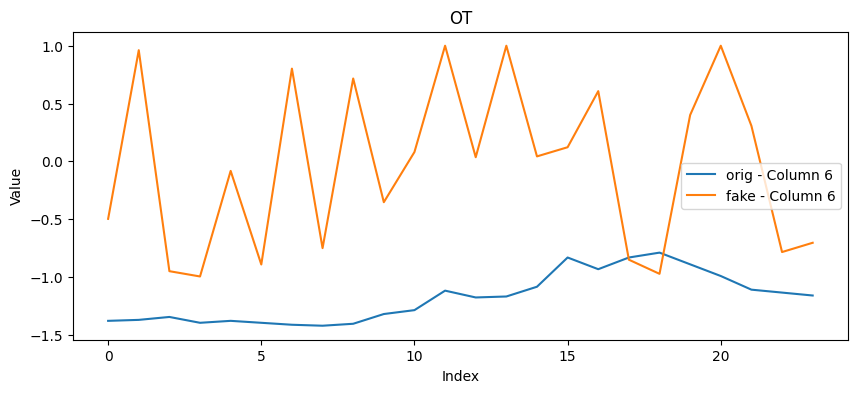

In [39]:
compare_orig_and_fake(test_data, one_sample, num_timestamps=24)

In [41]:
import scipy.stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

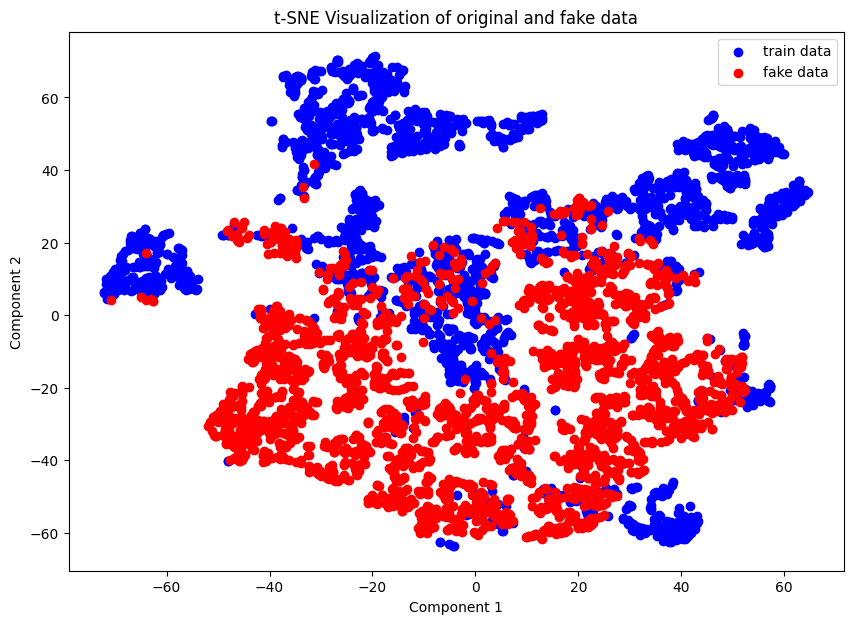

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_tsne(matrix1, matrix2):
    # Объединяем две матрицы для общего t-SNE преобразования
    combined_matrix = np.vstack((matrix1, matrix2))
    
    # Применяем t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(combined_matrix)
    
    # Разделяем t-SNE результаты для каждой из матриц
    tsne_matrix1 = tsne_results[:matrix1.shape[0]]
    tsne_matrix2 = tsne_results[matrix1.shape[0]:]
    
    # Визуализируем результаты
    plt.figure(figsize=(10, 7))
    
    # Синим цветом первая матрица
    plt.scatter(tsne_matrix1[:, 0], tsne_matrix1[:, 1], c='blue', label='train data')
    
    # Красным цветом вторая матрица
    plt.scatter(tsne_matrix2[:, 0], tsne_matrix2[:, 1], c='red', label='fake data')
    
    plt.title('t-SNE Visualization of original and fake data')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()


visualize_tsne(test_data, one_sample)
